In [1]:
import pandas as pd
import numpy as np
import os

from pysam import FastaFile, FastxFile

# 1. CATH preprocessing 
## 1.1. Download
- Sequences from the last release of CATH (v4.3.0) were downloaded from the [FTP](ftp://orengoftp.biochem.ucl.ac.uk/cath/releases/latest-release/sequence-data/cath-domain-seqs.fa)

# 1.2. Identification of sequences with present TM scores 
- we load a pairwise structural alignment file in order to identify which sequences are present in our training dataset
- we will load a largest dataset with 146M pairwise comparisons

In [2]:
# largest_file = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/flatiron/pairs_with_max_146M.csv.gz"
# df = pd.read_csv(largest_file, compression='gzip', usecols=["chain_1", "chain_2"])
# # collapse columns and identify unique entries
# chains = pd.concat([df["chain_1"], df["chain_2"]], axis=0).unique()

Checking N of unique proteins...

In [3]:
# chains.shape

**Idea**: ask Martin Steinegger for AFDB entries

## 1.3. Extracting sequences into separate file for MMSeqs2 runs

In [4]:
# cath_db = FastxFile("/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/flatiron/cath-domain-seqs.fa")
# output_file = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/flatiron/pairs_with_max_146M.fa"
# # load sequences into dict and adjust identifiers
# seq_dict = {entry.name.split("|")[-1].split("/")[0] : entry.sequence for entry in cath_db}
# with open(output_file, "w") as f:
#     for chain in chains:
#         f.write(f">{chain}\n{seq_dict[chain]}\n")

# 2. ProteinNet sequence extraction 
ProteinNET CASP 12 was downloaded from [Github repository](https://github.com/aqlaboratory/proteinnet)
- training set with different subsampling to emulate data scarse training mode (30%, 50%, 70%, 90%, 95%, 100%)
- validation 
- testing dataset

The first number in the ID of the validation FASTA reflects identity to a training data set. 

| ID% | N    |
|-----|------|
| 10  | 56 |
| 20  | 52 |
| 30  | 137 |
| 40  | 295 |
| 50  | 210 |
| 70  | 299 |
| 90  | 271 |

In [5]:
# proteinnet_dir = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/proteinnet/casp12"
# files = sorted(os.listdir(proteinnet_dir))

In [6]:
# for file in files:
#     filepath = os.path.join(proteinnet_dir, file)
#     output_file = filepath + ".fa"
#     with open(filepath, 'r') as f, open(output_file, 'w') as out:
#         for i, line in enumerate(f):
#             if "ID" in line:
#                 # grab next line
#                 idx = next(f).strip()
#                 # grab sequence two lines lower
#                 next(f)
#                 seq = next(f).strip()
#                 out.write(f">{idx}\n{seq}\n")

# 3. Recreating a ProteinNET split within pairs dataset 

In order to recreate train-validation-test split in our database we have to find hits to our pairwise db. Since databases aren't that large (100k nad 31k sequences) we can run search at full sensitivity - 7.5.  
Thus we will run 3 MMSeqs searches: 
- pairwise - training100
- pairwise - validation
- pairwise - test

If at least one sequence is found in the training set, the whole pair is moved to a training set.  
If at least one test sequence belongs to a validation set, the whole pair is move to a validation set. 

## 3.1. Training dataset

In [73]:
# !conda run -n deepfri \
#     mmseqs easy-search --max-seqs 60000 -s 7.5 --threads 16 --format-mode 4 --format-output query,target,fident,alnlen,mismatch,gapopen,qcov,tcov,evalue,bits\
#     /nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/proteinnet/casp12/training_100.fa \
#     /nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/flatiron/pairs_with_max_146M.fa \
#     training_vs_pairs.tsv \
#     tmp

In [8]:
result = pd.read_csv("training_vs_pairs.tsv", sep="\t")

In [9]:
# order by e-value and select top hits
result = result.sort_values("evalue").groupby("target").head(1)

(0.9, 1.0)

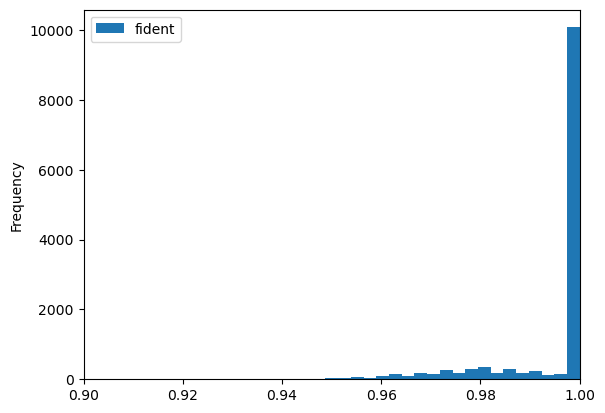

In [17]:
ax = result.query("qcov >= 0.9 and tcov >= 0.9").plot(kind="hist", y="fident", bins=300)
ax.set_xlim(0.9, 1)

94% identity looks like a reasonable cut-off to retrieve all hits

In [18]:
train_seqs = result.query("qcov >= 0.9 and tcov >= 0.9 and fident >= 0.94").target.unique()

## 3.2. Validation dataset

In [19]:
# !conda run -n deepfri \
#     mmseqs easy-search --max-seqs 60000 -s 7.5 --threads 16 --format-mode 4 --format-output query,target,fident,alnlen,mismatch,gapopen,qcov,tcov,evalue,bits\
#     /nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/proteinnet/casp12/validation.fa \
#     /nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/flatiron/pairs_with_max_146M.fa \
#     validation_vs_pairs.tsv \
#     tmp

In [20]:
val_df = pd.read_csv("validation_vs_pairs.tsv", sep="\t")

In [21]:
# order by e-value and select top hits
val_df = val_df.sort_values("evalue").groupby("target").head(1)

In [24]:
val_df["group"] = val_df["query"].apply(lambda x: int(x.split("#")[0]))

In [41]:
val_dict = val_df.query("qcov >= 0.9 and tcov >= 0.9 & fident >= 0.94").set_index("target")["group"].to_dict()

# 3.3. Test dataset 

In [ ]:
# !conda run -n deepfri \
#     mmseqs easy-search --max-seqs 60000 -s 7.5 --threads 16 --format-mode 4 --format-output query,target,fident,alnlen,mismatch,gapopen,qcov,tcov,evalue,bits\
#     /nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/proteinnet/casp12/testing.fa \
#     /nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/flatiron/pairs_with_max_146M.fa \
#     test_vs_pairs.tsv \
#     tmp

In [43]:
df = pd.read_csv("test_vs_pairs.tsv", sep="\t")

In [44]:
# order by e-value and select top hits
df = df.sort_values("evalue").groupby("target").head(1)

In [50]:
templates = df.query("qcov >= 0.9 and tcov >= 0.9 and fident >= 0.94").target

# 4. Annotating pairs

In [52]:
largest_file = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/flatiron/pairs_with_max_146M.csv.gz"
df = pd.read_csv(largest_file, compression='gzip', index_col=0)

In [53]:
df.loc[(df.chain_1.isin(templates)) | (df.chain_2.isin(templates)), "dataset"] = "test_template"
df.loc[(df.chain_1.isin(val_dict)) | (df.chain_2.isin(val_dict)), "dataset"] = "val"

In [64]:
# scan val pairs and assign highest value from the dict
val_df = df.query("dataset == 'val'")
val_df["dataset"] = val_df.apply(lambda x: max(val_dict.get(x.chain_1, 0), val_dict.get(x.chain_2, 0)), axis=1)
# append "val" to values
val_df["dataset"] = val_df["dataset"].apply(lambda x: f"val_{x}")
# assign to original df
df.loc[val_df.index, "dataset"] = val_df["dataset"]

/tmp/ipykernel_1347995/3307925943.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["dataset"] = val_df.apply(lambda x: max(val_dict.get(x.chain_1, 0), val_dict.get(x.chain_2, 0)), axis=1)
/tmp/ipykernel_1347995/3307925943.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["dataset"] = val_df["dataset"].apply(lambda x: f"val_{x}")


In [67]:
df.loc[(df.chain_1.isin(train_seqs) | df.chain_2.isin(train_seqs)), "dataset"] = "train"

In [72]:
# write to parquet
df.to_parquet("/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/flatiron/pairs_with_max_146M.proteinnet_split.parquet")